# 모듈

In [1]:
# 모듈 가져오기
import tensorflow as tf
tf.__version__

'2.8.2'

In [2]:
from tensorflow import keras
keras.__version__

'2.8.0'

# 데이터 준비

In [3]:
# 데이터
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

4431872/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
# 이미지 데이터 포멧 확인을 위해 케라스의 기반 엔진 획득
from tensorflow.keras import backend
# NHWC (6000, 28, 28, 1)
fmt = backend.image_data_format()
fmt

'channels_last'

In [5]:
# 환경변수 (데이터)
import numpy as np
_, PIXEL_H, PIXEL_W = X_train.shape # 필요없는걸 버릴 때는 _
PIXELS = PIXEL_H * PIXEL_W
LABEL_NUM = len(np.unique(y_train))
INPUT_CHANNEL = 1

In [6]:
# 입력을 위한 shape 정리 NHWC, 3D -> 4D
if fmt == 'channels_last':
  X_train = X_train.reshape(-1, PIXEL_H, PIXEL_W, INPUT_CHANNEL)
  X_test = X_test.reshape(-1, PIXEL_H, PIXEL_W, INPUT_CHANNEL)
else:
  X_train = X_train.reshape(-1, INPUT_CHANNEL, PIXEL_H, PIXEL_W)
  X_test = X_test.reshape(-1, INPUT_CHANNEL, PIXEL_H, PIXEL_W)

In [7]:
# 정규화 0 ~ 255 => 0 ~ 1 처리
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

In [8]:
np.max(X_train), np.min(X_train), np.max(X_test), np.min(X_test)

(1.0, 0.0, 1.0, 0.0)

In [9]:
# 정답은 범주형 데이터 -> 원핫인코딩 변환 -> 0과 1의 조합으로 표현된다
# 데이터가 늘어가면 (60000, 1) => (60000,10) -> 학습성능을 높이기 위해
y_train = keras.utils.to_categorical(y_train, LABEL_NUM)
y_test = keras.utils.to_categorical(y_test, LABEL_NUM)

In [10]:
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [11]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

# 모델 구축

In [12]:
from tensorflow.keras import models, layers

In [13]:
model = models.Sequential()

In [14]:
# input_shape = 참일때 값 if 조건식 else 거짓일때 값
input_shape = (PIXEL_H, PIXEL_W, INPUT_CHANNEL) if fmt == 'channels_last' else (PIXEL_H, PIXEL_W, INPUT_CHANNEL)
input_shape

(28, 28, 1)

In [15]:
model.add(layers.Conv2D(
    32, # 출력채널 수
    kernel_size=(5,5), # 커널의 크기
    strides=(1,1), # 커널의 이동량
    padding = 'same', # 합성곱을 통과한 feature map의 크기도 동일하게 28로 유지하기 위해 보정
    activation ='relu', # 활성화함수 activaiton map 
    input_shape = input_shape # 첫 번째 합성곱층에서만 정의, 입력되는 데이터의 형태를 지정
))
model.add(layers.MaxPool2D(
    pool_size=(2, 2), # 커널의 크기
    strides=None, # None이면 커널과 동일사이즈 -> 2 -> activation map의 크기는 반으로 줄어든다 
    padding='same', # 보정
))
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(32*2, (5,5), padding='same', activation='relu'))
model.add(layers.MaxPool2D(padding='same'))
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu' ))

model.add(layers.Dropout(0.1))
model.add(layers.Dense(LABEL_NUM, activation='softmax'))

In [16]:
# 컴파일 환경 구성 (학습시, 손실값 획득, 최적화, ...)
model.compile(
    optimizer='adam',
    loss = keras.losses.categorical_crossentropy,
    metrics = ['accuracy']
)

# 학습

In [17]:
# 환경변수
EPOCH = 30
BATCH_SIZE = 64

In [18]:
# 조기학습 종료
from tensorflow.keras.callbacks import EarlyStopping

# 5회 이상 val_loss 값의 변화가 거의 없다면 조기학습 종료 진행!!!
earlyStopping = EarlyStopping(patience=5)

In [19]:
# 학습
with tf.device('/device:GPU:0'):
  hist = model.fit(
      X_train,
      y_train,
      batch_size = BATCH_SIZE,
      epochs = EPOCH,
      callbacks = [earlyStopping],
      validation_split=0.2 # 훈련 데이터의 20%는 검증용으로 사용이된다
  )

Epoch 1/30
750/750 [==============================] - 16s 6ms/step - loss: 0.4297 - accuracy: 0.8436 - val_loss: 0.2959 - val_accuracy: 0.8926
Epoch 2/30
750/750 [==============================] - 4s 5ms/step - loss: 0.2822 - accuracy: 0.8982 - val_loss: 0.2733 - val_accuracy: 0.9001
Epoch 3/30
750/750 [==============================] - 4s 5ms/step - loss: 0.2380 - accuracy: 0.9118 - val_loss: 0.2541 - val_accuracy: 0.9078
Epoch 4/30
750/750 [==============================] - 4s 6ms/step - loss: 0.2093 - accuracy: 0.9225 - val_loss: 0.2306 - val_accuracy: 0.9172
Epoch 5/30
750/750 [==============================] - 4s 6ms/step - loss: 0.1859 - accuracy: 0.9292 - val_loss: 0.2386 - val_accuracy: 0.9146
Epoch 6/30
750/750 [==============================] - 5s 7ms/step - loss: 0.1620 - accuracy: 0.9383 - val_loss: 0.2290 - val_accuracy: 0.9169
Epoch 7/30
750/750 [==============================] - 4s 6ms/step - loss: 0.1461 - accuracy: 0.9445 - val_loss: 0.2245 - val_accuracy: 0.9225
Epoch

In [20]:
# 테스트
model.evaluate(X_test, y_test)
# 검증용 훈련용 테스트용 정확도 결과를 보고 모델 조정, 수치 조정, 데이터 조정 등 작업을 진행

313/313 [==============================] - 1s 4ms/step - loss: 0.3186 - accuracy: 0.9138


[0.3186323344707489, 0.9138000011444092]

In [23]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

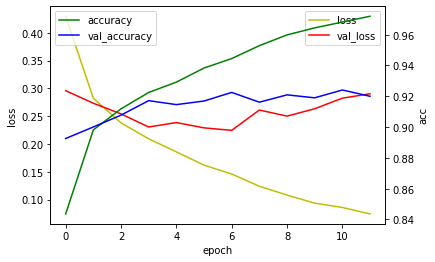

In [24]:
# 학습 결과 시각화
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# y축의 양쪽을 다 사용하기 위해
acc_ax = ax.twinx()

# loss
ax.plot(hist.history['loss'], 'y', label='loss')
ax.plot(hist.history['val_loss'], 'r', label='val_loss')

# acc
acc_ax.plot(hist.history['accuracy'], 'g', label='accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')

# 축에 이름 부여
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
acc_ax.set_ylabel('acc')

ax.legend()
acc_ax.legend()

plt.show()